In [23]:
# All imports and warnings.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import warnings
import os

# Turn off warnings.
warnings.filterwarnings("ignore")

In [24]:
# Printing controls and path settings.
print_dist_test_plot = False  # Set to True to plot the simulated paths.
rolling_hy_mean = True  # Set to True to use rolling mean for hypothesis testing.
print_simulated_paths = False  # Set to True to print simulated paths.

# Save current working directory.
cwd = os.getcwd()

First, we determine all of the parameters for the simulation:
* $N$ is the number of simulated paths.
* $h$ is the size of the time window, in years.
* $T$ is the total number of years in the simulation, that comes from adding $T_{is}$ and $T_{oos}$.

This comes from having data to fit the model, $T_{is}$, and then using the model to make predictions for $T_{oos}$ years. The number of time steps in the simulation is given by:
* $N_{is}$ and $N_{oos}$ are the number of time steps in-sample and out-of-sample, respectively.
* $T_{is}$ and $T_{oos}$ are the in-sample and out-of-sample time periods, respectively.

We also add a seed for reproducibility and set the level of confidence for the goodness of fit tests at $\alpha=0.01$.

```python

In [25]:
# 0. Setting simulation parameters.
N = 10000  # Number of simulated paths
h = 5  # Number of years to average over
N_is = 200 // h  # Number of in-sample h-year periods. Set to generate around 200 years of data.
T_is = N_is * h  # Number of time periods in-sample
N_oos = 25 // h  # Number of out-of-sample h-year periods. Set to generate around 25 years of data.
T_oos = N_oos * h  # Number of time periods out-of-sample
T = T_is + T_oos + 1  # Number of time periods per path
print("h:", h, "T_is:", T_is, "T_os:", T_oos, "T:", T)

# Set significance level for hypothesis testing.
alpha = 0.01  # Significance level for hypothesis testing

# Set random seed for reproducibility.
np.random.seed(1409 * N)

h: 5 T_is: 200 T_os: 25 T: 226


Now, regarding the parameters of the VAR model for this set of equations:
$$r_{t+1} = b*{dp}_t + \epsilon_{t}$$
$$dp_{t+1} = \phi*{dp}_t + \delta_{t}$$
- For the dividend-price ratio:
$$\phi = 0.92$$
$${\sigma}_{\delta} = 0.152$$
$${\rho}_{{\delta},{\epsilon}} = -0.72$$
In the generation process, we have a lower bound for the dividend-price ratio of $-0.445$.
- For the excess return:
$$b = 0.16$$
$${\sigma}_{\epsilon} = 0.192$$
$$\mu = 0.0607$$

In [26]:
# VAR(1) process parameters.

# dp process:
phi = 0.92  # AR coefficient for dp
sig_del = 0.152  # Volatility parameter for dp noise (delta)
corr_del_eps = -0.72  # Correlation between dp and return noise (epsilon)
dp_t_lb = -0.445  # Lower bound for dp process

# r process:
b = 0.16  # Coefficient for demeaned log return calculation
sig_eps = 0.192  # Volatility parameter for return noise (epsilon)
lnr_mean = 0.0607  # Mean of log returns (lnr); taken from Andries paper

We initialize the arrays that will manage the data. We have one array for:
- the dividend-price ratio, $dp_t$.
- the returns, $r_t$.
- the demeaned log returns, $r_{t+1} - \text{Mean}(\ln(r))$.

In [27]:
# 1. Initialize simulation arrays.
# Each array is of shape (T, N)
# ----------------------------------------
dp_1t_act = np.zeros((T, N))  # Latent variable (dp)
lnr_ht_fit = np.zeros((T, N))  # Fitted dp values

r_t_demeaned = np.zeros((T, N))  # Demeaned log returns
lnr_1t_act = np.zeros((T, N))  # Log returns
lnr_ht_act = np.zeros((T, N))  # h-year (h-period) returns

dp_t_fut = np.zeros((T, N))  # Expected future dp
lnr_ht_fut = np.zeros((T, N))  # Expected h-year returns

# Set initial condition for dp: first row is zero for all simulation runs.
dp_1t_act[0, :] = 0

We now generate two random noise series, $\epsilon_t$ and $\delta_t$, that meet the correlation coefficient of $\rho_{\delta,\epsilon} = -0.72$ for all simulated paths.

In [28]:
# 2. Draw 2 correlated random noise series.
# Instead of a Tx2 matrix (for one simulation), we generate a Tx2xN array.
# ----------------------------------------

# Standard normal noise for each simulation.
M = np.random.randn(T, 2, N)

# Desired 2x2 correlation matrix.
R = np.array([[1, corr_del_eps], [corr_del_eps, 1]])

# Compute Cholesky decomposition of R (L is 2x2 lower triangular such that R = L Lᵀ).
L = np.linalg.cholesky(R)
print(L)
# Multiply each 2-vector by L using einsum. Now M has shape (T, 2, N)
# M = np.einsum("tjs,jk->tks", M, L)
M = np.einsum('jk,tks->tjs', L, M)  
print("M shape:", M.shape)

# Rearrange axes so that noise variables are in the second dimension:
# Now, extract the first and second noise series for each simulation:
x = M[:, 0, :] * sig_del  # shape (T, N) scaled by sig_del
y = M[:, 1, :] * sig_eps  # shape (T, N) scaled by sig_eps

print("x shape:", x.shape)
print("y shape:", y.shape)

# Compute the correlation between the two noise series.
corr_xy = np.corrcoef(x.flatten(), y.flatten())[0, 1].round(4)
print("Correlation between the two noise series across T and N:", corr_xy)

per_path_corrs = [
    np.corrcoef(x[:, n], y[:, n])[0, 1] for n in range(x.shape[1])
]
print("Mean correlation across simulation paths:", np.mean(per_path_corrs).round(4))
print("Std dev of per-path correlations:", np.std(per_path_corrs).round(4))

[[ 1.          0.        ]
 [-0.72        0.69397406]]
M shape: (226, 2, 10000)
x shape: (226, 10000)
y shape: (226, 10000)
Correlation between the two noise series across T and N: -0.7199
Mean correlation across simulation paths: -0.7192
Std dev of per-path correlations: 0.0321


<b>(1)</b> We first simulate the $dp_t$ process, which is a stationary AR(1) process, following the equation:
$$dp_{t+1} = \phi*{dp}_t + \delta_{t}$$
where $\delta_t$ is a normal random variable with mean 0 and standard deviation ${\sigma}_{\delta}$. 

If the value of $dp_t$ is less than the lower bound, we set it to the lower bound.

In [29]:
# 3. Simulate the yearly dp process (dp_t). x is the noise for the signal
for t in range(1, T):
    dp_1t_act[t, :] = phi * dp_1t_act[t - 1, :] + x[t, :]
    # If any simulation run yields a value less than -0.445, set it equal to -0.445.
    dp_1t_act[t, :] = np.where(dp_1t_act[t, :] >= dp_t_lb, dp_1t_act[t, :], dp_t_lb)

# Print first 5 rows of the 1st simulation run.
print("First 5 rows of the dp process for the first simulation run:")
print(dp_1t_act[:5, 0])

First 5 rows of the dp process for the first simulation run:
[ 0.         -0.04364417  0.12022191 -0.06271859 -0.0573875 ]


<b>(2)</b> Now, we calculate the <i>h</i>-year expected returns, scaling dividend by the coefficient ($b^{'}$) and adding a constant term ($\mu$) to the dividend-price ratio. The expected returns are given by:
$$r_{h,t=hn}^{f} = h\mu + b^{'}*dp_{t=hn} \text{ with } n=1,...,N_{is}$$
$$b^{'} = b*\displaystyle\sum_{i=0}^{h-1} \phi^i$$
For $h=5$, we have:
$$b^{'} = b*(1 + \phi^1 + \phi^2 + \phi^3 + \phi^4)\approx 0.681837$$

In [30]:
# 4. Compute fitted h-year r_t based on simulated dp_t.
# Every 5th period from index 0 to 220 (MATLAB 1:5:221) is scaled: fitted = (0.0607*5 + 0.681837 * dp)
# ----------------------------------------
# Create a function to calculate b' value for the given number of years.
def calculate_b_prime(in_b, in_phi, in_n_years):
    """
    Function to calculate the b' value for the given number of years.
    """
    phi_term = 0
    for i in range(in_n_years):
        phi_term += in_phi**i
    out_b_prime = in_b * phi_term
    return out_b_prime

b_prime = calculate_b_prime(b, phi, h)
print("b_prime:", round(b_prime, 6))

# Calculate fitted returns for every h-th period.
lnr_ht_fit[0 : T - h : h, :] = (lnr_mean * h) + b_prime * dp_1t_act[0 : T - h : h, :]
print("First entries of the fitted retuns:")
print(lnr_ht_fit[0:(2*h)+1, 0].round(4))
print("Omitting the skipped entries:")
print(lnr_ht_fit[0:(2*h)+1:h, 0].round(4))

b_prime: 0.681837
First entries of the fitted retuns:
[0.3035 0.     0.     0.     0.     0.2825 0.     0.     0.     0.
 0.4838]
Omitting the skipped entries:
[0.3035 0.2825 0.4838]


<b>(3)</b> We now compute the historical yearly returns (by multiplying $dp_t$ by $b$ and adding $\mu$ and the noise term $\epsilon_t$). After this, we calculate the <i>h</i>-year annualized returns.

In [31]:
# 5. Compute historical yearly returns.
for t in range(1, T):
    r_t_demeaned[t, :] = b * dp_1t_act[t - 1, :] + y[t, :]

lnr_1t_act = r_t_demeaned + lnr_mean

# Print first 5 rows of the 1st simulation run.
print(f"The returns from t = 1 until t = {h} are:")
print(lnr_1t_act[1 : (1 * h) + 1, 0])
print("that add up to:")
print(round(lnr_1t_act[1 : (1 * h) + 1, 0].sum(),8))

print(f"\nThe returns from t = {h + 1} until t = {2*h} are:")
print(lnr_1t_act[6 : (2 * h) + 1, 0])
print("that add up to:")
print(round(lnr_1t_act[6 : (2 * h) + 1, 0].sum(),8))

The returns from t = 1 until t = 5 are:
[ 0.21390124 -0.12108326  0.30090343  0.25279277  0.20571821]
that add up to:
0.85223238

The returns from t = 6 until t = 10 are:
[ 0.43783398 -0.22182686 -0.29934576 -0.20971747 -0.08537054]
that add up to:
-0.37842664


In [32]:
# 6. Compute historical h-year returns.
for t in range(h, T, h):
    # Sum lnrt from t-(h-1) to t (inclusive) for each simulation run.
    lnr_ht_act[t, :] = np.sum(lnr_1t_act[t - (h - 1) : t + 1, :], axis=0)

# Print first 5 rows of the 1st simulation run.
print(lnr_ht_act[0 : (2 * h) + 1 : h, 0])

[ 0.          0.85223238 -0.37842664]


In [33]:
# 7. Annualize both fitted and historical h-year returns.
lnr_ht_fit[0 : T - h : h, :] = lnr_ht_fit[0 : T - h : h, :] / h
lnr_ht_act[h:T:h, :] = lnr_ht_act[h:T:h, :] / h

# Print first 5 rows of the 1st simulation run.
print(lnr_ht_act[0 : (2 * h) + 1 : h, 0])

[ 0.          0.17044648 -0.07568533]


So far, we have obtained the following series for the time horizon from $t=0$ to $t=T$:
- $dp_{t}^{act}$: the historical yearly dividend-price ratio from <b>(1)</b>.
- $r_{h,t=hn}^{fit}$: the fitted annualized <i>h</i>-year returns from <b>(2)</b>.
- $r_{t}^{act}$: the historical yearly returns from <b>(3)</b>.
- $r_{h,t=hn}^{act}$: the historical annualized <i>h</i>-year returns from <b>(3)</b>.

We now compute for the out-of-sample period, from $T_{is}+1$ to $T$, the following series:
- $dp_{t}^{fut}$: the forecasted dividend-price ratio.
- $r_{h,t=hn}^{fut}$: the forecasted annualized <i>h</i>-year returns.

In [34]:
# 8. Compute expected future dp.
for t in range(T_is + 1, T):
    exponent = (t + 1) - (T_is + 1)  # when t=201, exponent=1, etc.
    dp_t_fut[t, :] = (phi**exponent) * dp_1t_act[T_is, :]
# Set the value at index T_is explicitly:
dp_t_fut[T_is, :] = dp_1t_act[T_is, :]

In [35]:
# 9. Scale up these expected dp to get expected 5-year returns.
# For t = 206:5:226 in MATLAB (Python indices 205,210,...,225), set:
#   Exlnr5t[t, :] = 0.681837 * Exlndt_lnpt[t-5, :] + 0.0607*5
# -------------------------------
for t in range(T_is + h, T, h):
    lnr_ht_fut[t, :] = b_prime * dp_t_fut[t - h, :] + lnr_mean * h

# (Optional: To save the simulated data as CSV, you could stack the arrays and use numpy.savetxt)

We process the SPX yearly returns to obtain the annualized returns for the <i>h</i>-year periods.

In [ ]:
# 10. Process SPX yearly and h-year annualized returns.
spx_data = pd.read_csv(cwd + "/data/SPX_Returns.csv", skiprows=6, sep=";")
# Convert the date column to datetime format.
spx_data["Date"] = pd.to_datetime(spx_data["Date"], format="%Y-%m-%d")

# Set the date column as the index.
spx_data.set_index("Date", inplace=True)

# Convert the data to numeric, forcing errors to NaN.
spx_data = spx_data.apply(pd.to_numeric, errors="coerce")

# Sort the index to ensure it's in ascending order.
spx_data.sort_index(inplace=True)

# Rename the last price and change percentage columns for clarity.
spx_data.rename(columns={"PX_LAST": "price", "CHG_PCT_1D": "return"}, inplace=True)

# Divide the return column by 100 to convert percentage to decimal.
spx_data["return"] = spx_data["return"] / 100

# Calculate the annualized returns of the last h years.
spx_data["annualized_return_hy"] = (
    (1 + spx_data["return"]).rolling(window=h).apply(np.prod, raw=True)
) ** (1 / h) - 1

# Get the data of every fifth year.
if not rolling_hy_mean:
    # Select every h-th row starting from the first row.
    spx_data = spx_data.iloc[::h]

# Print the number of non-null values in the annualized return column.
print(
    "Number of non-null values in annualized return column:",
    spx_data["annualized_return_hy"].count(),
)

Number of non-null values in annualized return column: 64


In [ ]:
# 11. Compute the summary statistics for each simulation.
# ----------------------------------------
# Select the indices corresponding to the computed 5-year returns:
return_ht_indices = np.arange(h, T, h)  # This gives [5, 10, 15, ..., 225]
signal_ht_indices = np.arange(
    0, T - h, h
)  # MATLAB: 1:5:221 -> Python: indices 0,5,...,220

# Select the indices corresponding to the annual returns:
return_1t_indices = np.arange(1, T, 1)  # This gives [1, 2, 3, ..., 225]

data = []  # List to store our results for each simulation

# Loop over each simulation run (each column)
for i in range(N):

    # Create a string with the index of the simulation run but always having three digits, adding zeros if needed.
    i_str = str(i + 1).zfill(4)

    # Extract the 5-year actual returns for this simulation.
    ret_1t_i = lnr_1t_act[return_1t_indices, i]
    ret_ht_i = lnr_ht_act[return_ht_indices, i]

    # Extract the fitted values for this simulation.
    sig_ht_i = lnr_ht_fit[signal_ht_indices, i]

    # Extract the first h-year actual return after the in-sample period.
    ret_ht_i_oos = lnr_ht_act[N_is, i]
    sig_ht_i_oos = lnr_ht_fit[T_is, i]

    # Calculate average, standard deviation, min, and max of these returns.
    ret_ht_i_avg = np.mean(ret_ht_i)
    ret_ht_i_std = np.std(ret_ht_i)
    ret_ht_i_min = np.min(ret_ht_i)
    ret_ht_i_max = np.max(ret_ht_i)

    # Compute the correlation between the signal and the 5-year returns.
    # Note: This uses np.corrcoef which returns a 2x2 matrix.
    sig_ret_corr = np.corrcoef(sig_ht_i, ret_ht_i)[0, 1]

    # Compute the correlation between the returns and the returns 5 years before.
    # This is done by taking the returns at the current index and the returns the last period.
    lag_ret_corr = (
        np.corrcoef(ret_ht_i[:-1], ret_ht_i[1:])[0, 1] if len(ret_ht_i) > 1 else 0
    )

    # Compute the correlation between the returns and the signal 5 years before and the returns.
    lag_sig_ret_corr = (
        np.corrcoef(sig_ht_i[:-1], ret_ht_i[1:])[0, 1] if len(ret_ht_i) > 1 else 0
    )

    # Perform a Kolmogorov-Smirnov test to check if the returns distribution is similar to that of the SPX returns.
    alpha = 0.01  # Significance level for the KS test
    ks_ht_stat_i, ks_ht_p_value_i = stats.ks_2samp(
        ret_ht_i, spx_data["annualized_return_hy"]
    )

    # Plot the histogram of the returns and the SPX returns for comparison.
    ks_title = f"Histogram of Returns for Simulation {str(i + 1)} {'Rolling 5Y' if rolling_hy_mean else 'Non-Rolling 5Y'}"
    ks_filename = (
        f"{i_str}_KS_Test_{'Rolling 5Y' if rolling_hy_mean else 'Non-Rolling 5Y'}.png"
    )

    if print_dist_test_plot:
        plt.figure(figsize=(10, 6))
        plt.hist(
            ret_ht_i,
            bins=59,
            alpha=0.5,
            range=(-0.195, 0.395),
            label="Simulated Returns",
            density=True,
        )
        plt.hist(
            spx_data["annualized_return_hy"],
            bins=59,
            alpha=0.5,
            range=(-0.195, 0.395),
            label="SPX Returns",
            density=True,
        )
        plt.title(ks_title)
        plt.xlabel("Returns")
        plt.ylabel("Density")
        plt.legend()
        plt.grid()
        plt.savefig(f"ks_tests//KS_Test_{h}Y_Graphs/{ks_filename}")
        plt.close()

    # Plot a QQ plot to compare the quantiles of the simulated returns and SPX returns.
    qq_title = f"QQ Plot of Returns for Simulation {str(i + 1)} {'Rolling 5Y' if rolling_hy_mean else 'Non-Rolling 5Y'}"

    qq_filename = (
        f"{i_str}_QQ_Plot_{'Rolling 5Y' if rolling_hy_mean else 'Non-Rolling 5Y'}.png"
    )

    if print_dist_test_plot:
        plt.figure(figsize=(10, 6))
        stats.probplot(ret_ht_i, dist="norm", plot=plt)
        plt.title(qq_title)
        plt.xlabel("Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.grid()
        plt.savefig(f"ks_tests//KS_Test_{h}Y_Graphs/{qq_filename}")
        plt.close()

    # Perform a KS test to check if the returns distribution is similar to that of the SPX returns.
    ks_1t_stat_i, ks_1t_p_value_i = stats.ks_2samp(ret_1t_i, spx_data["return"])

    # Plot the histogram of the returns and the SPX returns for comparison.
    ks_title = f"Histogram of Returns for Simulation {str(i + 1)} {'Rolling 1Y' if rolling_hy_mean else 'Non-Rolling 1Y'}"
    ks_filename = f"{i_str}_KS_Test_{'Rolling 1Y' if rolling_hy_mean else 'Non-Rolling 1Y'}_Annual.png"

    if print_dist_test_plot:
        plt.figure(figsize=(10, 6))
        plt.hist(
            ret_1t_i,
            bins=59,
            alpha=0.5,
            range=(-0.195, 0.395),
            label="Simulated Returns",
            density=True,
        )
        plt.hist(
            spx_data["return"],
            bins=59,
            alpha=0.5,
            range=(-0.195, 0.395),
            label="SPX Returns",
            density=True,
        )
        plt.title(ks_title)
        plt.xlabel("Returns")
        plt.ylabel("Density")
        plt.legend()
        plt.grid()
        plt.savefig(f"ks_tests//KS_Test_1Y_Graphs/{ks_filename}")
        plt.close()

    # Append the results for this simulation run.
    data.append(
        [
            i + 1,
            ret_ht_i_avg,
            ret_ht_i_std,
            sig_ret_corr,
            lag_ret_corr,
            lag_sig_ret_corr,
            alpha,
            ks_ht_stat_i,
            ks_ht_p_value_i,
            ks_1t_stat_i,
            ks_1t_p_value_i,
            ret_ht_i_min,
            ret_ht_i_max,
            ret_ht_i_oos,
            sig_ht_i_oos,
        ]
    )

# Create a pandas DataFrame to nicely display the table
df = pd.DataFrame(
    data,
    columns=[
        "Simulation",
        f"{h}Y Return Avg",
        f"{h}Y Return Std",
        "Correlation Signal-Return",
        "Lagged Return Autocorrelation",
        "Correlation Lagged Signal-Return",
        "Significance Level",
        f"KS Statistic ({h}Y)",
        f"KS p-value ({h}Y)",
        "KS Statistic (1Y) Original",
        "KS p-value (1Y) Original",
        f"{h}Y Return Min",
        f"{h}Y Return Max",
        f"{h}Y Return OOS",
        f"{h}Y Signal OOS",
    ],
)

# Print the average and standard deviation of the h-year annualized returns.
print(f"{h}Y Annualized Returns Avg:", round(df[f"{h}Y Return Avg"].mean(), 4))
print(f"{h}Y Annualized Returns Std:", round(df[f"{h}Y Return Std"].mean(), 4))

# Add two columns to check if the minimum return and the maximum return are between two values.
min_return_SPX = spx_data["annualized_return_hy"].min()
max_return_SPX = spx_data["annualized_return_hy"].max()
avg_return_SPX = spx_data["annualized_return_hy"].mean()
std_return_SPX = spx_data["annualized_return_hy"].std()
print("Min SPX return:", round(min_return_SPX, 4))
print("Max SPX return:", round(max_return_SPX, 4))
print("Avg SPX return:", round(avg_return_SPX, 4))
print("Std SPX return:", round(std_return_SPX, 4))
df["SPX Min Annual Return"] = min_return_SPX
df["SPX Max Annual Return"] = max_return_SPX
df["SPX Avg Annual Return"] = avg_return_SPX
df["SPX Std Annual Return"] = std_return_SPX

# Check if the minimum and maximum returns are between the SPX returns.
df["Min Return Compliant"] = (df[f"{h}Y Return Min"] >= min_return_SPX) & (
    df[f"{h}Y Return Min"] <= max_return_SPX
)
df["Max Return Compliant"] = (df[f"{h}Y Return Max"] >= min_return_SPX) & (
    df[f"{h}Y Return Max"] <= max_return_SPX
)

# Check if the volatility of the returns is between the SPX returns.
df["SD Return Compliant"] = (df[f"{h}Y Return Std"] >= std_return_SPX - 0.05) & (
    df[f"{h}Y Return Std"] <= std_return_SPX + 0.05
)

# Check if the KS test p-value is less than the significance level.
df["KS Compliant"] = df[f"KS p-value ({h}Y)"] <= alpha

# Check if the correlation between the signal and the returns is +/- 0.05 of the parameter.
df["S-R Correlation Compliant"] = (
    df["Correlation Signal-Return"] >= corr_del_eps - 0.05
) & (df["Correlation Signal-Return"] <= corr_del_eps + 0.05)


df["Full Compliant"] = (
    df["Min Return Compliant"]
    & df["Max Return Compliant"]
    & df["KS Compliant"]
    & df["SD Return Compliant"]
    # & df["S-R Correlation Compliant"]
)

# Delete the rows where both returns are not compliant.
# df = df[df["Full Compliant"]]

# Save the DataFrame to a Excel file.
results_filename = (
    f"sim_results/Simulation_Results_Non-Rolling {h}Y.xlsx"
    if not rolling_hy_mean
    else f"sim_results/Simulation_Results_Rolling {h}Y.xlsx"
)
df.to_excel(results_filename, index=False)

# Print the amount of compliant simulations.
print("Number of compliant simulations:", df["Full Compliant"].sum())

5Y Annualized Returns Avg: 0.0706
5Y Annualized Returns Std: 0.085
Min SPX return: -0.0573
Max SPX return: 0.2618
Avg SPX return: 0.0747
Std SPX return: 0.0681
Number of compliant simulations: 196


In [38]:
# 12. Save the simulation parameters for the compliant simulations.
df_out = df[
    [
        "Simulation",
        f"{h}Y Return Avg",
        f"{h}Y Return Std",
        "Correlation Signal-Return",
        "Lagged Return Autocorrelation",
        "Correlation Lagged Signal-Return",
        "Significance Level",
        f"KS Statistic ({h}Y)",
        f"KS p-value ({h}Y)",
        "KS Statistic (1Y) Original",
        "KS p-value (1Y) Original",
        f"{h}Y Return Min",
        f"{h}Y Return Max",
    ]
].copy()

In [39]:
# 13. Save all relevant dataframes to Excel files.
# Save all dp_1t_act values into an Excel file.
dp_filename = (
    f"Dataframes/dp_1t_act_Non-Rolling {h}Y.xlsx"
    if not rolling_hy_mean
    else f"Dataframes/dp_1t_act_Rolling {h}Y.xlsx"
)
# Discard non-full compliant simulations.
dp_df = pd.DataFrame(dp_1t_act[:, df["Full Compliant"] == True], columns=[f"Simulation {i+1}" for i in df[df["Full Compliant"] == True].index])
dp_df.to_excel(dp_filename, index=False)

# Save all lnr_1t_act values into an Excel file.
lnr_filename = (
    f"Dataframes/lnr_1t_act_Non-Rolling {h}Y.xlsx"
    if not rolling_hy_mean
    else f"Dataframes/lnr_1t_act_Rolling {h}Y.xlsx"
)
lnr_df = pd.DataFrame(lnr_1t_act[:, df["Full Compliant"] == True], columns=[f"Simulation {i+1}" for i in df[df["Full Compliant"] == True].index])
lnr_df.to_excel(lnr_filename, index=False)

# Save all lnr_ht_act values into an Excel file.
lnr_ht_filename = (
    f"Dataframes/lnr_ht_act_Non-Rolling {h}Y.xlsx"
    if not rolling_hy_mean
    else f"Dataframes/lnr_ht_act_Rolling {h}Y.xlsx"
)
lnr_ht_df = pd.DataFrame(lnr_ht_act[:, df["Full Compliant"] == True], columns=[f"Simulation {i+1}" for i in df[df["Full Compliant"] == True].index])
lnr_ht_df.to_excel(lnr_ht_filename, index=False)

# Save all lnr_ht_fit values into an Excel file.
lnr_ht_fit_filename = (
    f"Dataframes/lnr_ht_fit_Non-Rolling {h}Y.xlsx"
    if not rolling_hy_mean
    else f"Dataframes/lnr_ht_fit_Rolling {h}Y.xlsx"
)
lnr_ht_fit_df = pd.DataFrame(lnr_ht_fit[:, df["Full Compliant"] == True], columns=[f"Simulation {i+1}" for i in df[df["Full Compliant"] == True].index])
lnr_ht_fit_df.to_excel(lnr_ht_fit_filename, index=False)

In [ ]:
# 13. Plot the results.
# Define time vectors for plotting (MATLAB: k, g, m, n)
k = np.arange(-N_is + 1, 2)  # from -40 to 0 (inclusive)
g = np.arange(-N_is + 1, 1)  # from -40 to -1
m = np.arange(1, 3)  # 0 to 4
n = np.arange(0, 2)  # -1 to 4

plot_counter = 0

# We'll plot for each simulation run:
for sim in range(N):
    # Only plot compliant simulations.
    if not df["Full Compliant"].iloc[sim]:
        continue

    # Skip if the control variable is set to False.
    if not print_simulated_paths:
        print("Simulation run:", sim + 1)
        print(lnr_ht_fit[T_is, sim])
        print(lnr_ht_act[T_is : T_is + h + 1 : h, sim])
        continue

    plt.figure(figsize=(8, 6))
    # Plot Index Return: 5-year returns from MATLAB indices 6:5:201 -> Python indices 5,10,...,200
    plt.plot(
        g,
        100 * lnr_ht_act[h : T - T_oos : h, sim],
        "-r",
        linewidth=1.5,
        label="Index Return",
    )
    # Plot Variable A: fitted values from MATLAB indices 1:5:201 -> Python indices 0,5,...,200
    plt.plot(
        k,
        100 * lnr_ht_fit[0 : T - T_oos : h, sim],
        "-.b",
        linewidth=1.5,
        label="Variable A",
    )
    # Plot a marker at time 0: fitted(201) in MATLAB corresponds to Python index 200
    plt.plot(1, 100 * lnr_ht_fit[T_is, sim], "oy", markersize=8, markeredgewidth=3)
    # Plot fitted values from MATLAB indices 201:5:221 -> Python indices 200,205,...,220 over m = 0:4
    # plt.plot(m, 100 * fitted[200:206:5, sim], "-.", linewidth=1.5)
    # Plot 5-year returns from MATLAB indices 201:5:226 -> Python indices 200,205,...,225 over n = -1:4
    plt.plot(n, 100 * lnr_ht_act[T_is : T_is + h + 1 : h, sim], ":r", linewidth=1.5)

    plt.grid(True, which="both")
    plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(5))
    plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))
    plt.gca().yaxis.tick_right()  # place y-axis on right side
    plt.axis([-N_is + 1, 4, -20, 40])
    plt.legend()

    # Change y-axis tick labels to include a '%' sign
    yticks = plt.gca().get_yticks()
    plt.gca().set_yticklabels([f"{int(tick)}%" for tick in yticks])

    plt.title(f"Simulation Run {sim+1}")
    plt.xlabel("Time")
    plt.ylabel("Annualized Return (%)")
    plt.tight_layout()

    # Create a string with the index of the simulation run but always having three digits, adding zeros if needed.
    sim_str = str(sim + 1).zfill(4)

    # Save the plot as a PNG file in a subfolder named "Simulation_Paths".
    plt.savefig(f"sim_paths/Simulation_Paths_{h}Y/{sim_str}_Path.png")

    # Print every 5th plot to the screen
    if plot_counter < 5:
        plt.show()
        print(lnr_ht_fit[T_is, sim])
        print(lnr_ht_act[T_is : T_is + h + 1 : h, sim])
        plot_counter += 1

    plt.close()

Simulation run: 43
0.09844577364221374
[0.09954779 0.19853354]
Simulation run: 66
0.1091577729743733
[ 0.18016682 -0.02130765]
Simulation run: 119
0.0116422374444075
[0.05594534 0.01063779]
Simulation run: 163
0.185204312278952
[0.01036    0.10181224]
Simulation run: 250
0.05263758532306913
[0.12271357 0.13040107]
Simulation run: 275
0.06511271705577455
[0.0226953  0.07646791]
Simulation run: 289
0.09009945981471605
[0.06405461 0.1713452 ]
Simulation run: 303
0.09845031753056929
[0.25331981 0.02760607]
Simulation run: 329
0.060718758589536424
[-0.00712074 -0.04800102]
Simulation run: 482
0.06392442103641952
[-0.00048635  0.11259215]
Simulation run: 498
0.048375695089710916
[ 0.07759147 -0.03480795]
Simulation run: 599
0.05257817311591586
[0.08594858 0.04101507]
Simulation run: 603
0.07863727157383918
[0.0448806 0.1525775]
Simulation run: 632
1.6511129599994234e-05
[0.01788555 0.05121415]
Simulation run: 643
0.06730360130311384
[-0.02898041  0.13683532]
Simulation run: 663
0.12230830075

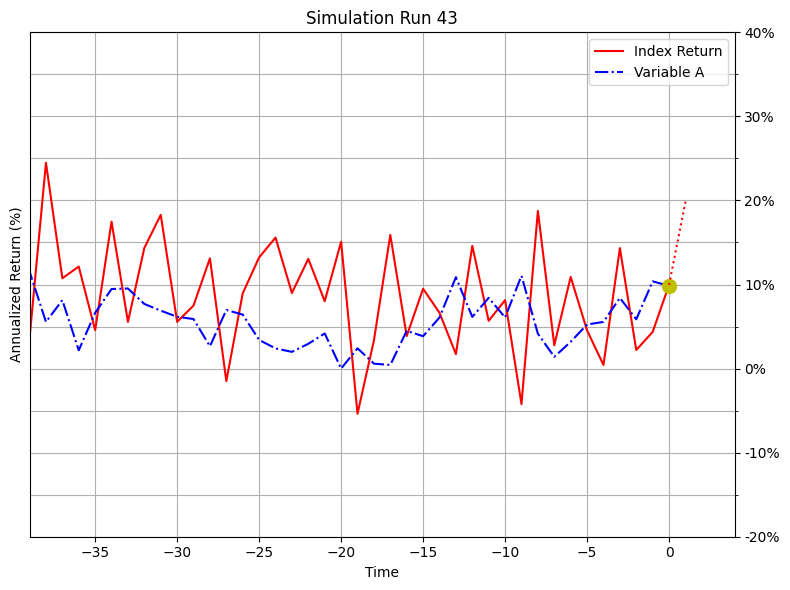

In [ ]:
# Aligned graph (no lag).

# Get the data for simulation 43.
lnr_ht_act_43 = lnr_ht_act[:, 42]
lnr_ht_fit_43 = lnr_ht_fit[:, 42]

# Define time vectors for plotting (MATLAB: k, g, m, n)
k = np.arange(-N_is, 1)  # from -40 to 0 (inclusive)
g = np.arange(-N_is + 1, 1)  # from -40 to -1
m = np.arange(0, 1)  # 0 to 4
n = np.arange(0, 2)  # -1 to 4

# Plot the data for simulation 43.
plt.figure(figsize=(8, 6))
plt.plot(
    g,
    100 * lnr_ht_act_43[h : T - T_oos : h],
    "-r",
    linewidth=1.5,
    label="Index Return",
)
plt.plot(
    k,
    100 * lnr_ht_fit_43[0 : T - T_oos : h],
    "-.b",
    linewidth=1.5,
    label="Variable A",
)
plt.plot(m, 100 * lnr_ht_fit_43[T_is], "oy", markersize=8, markeredgewidth=3)
plt.plot(n, 100 * lnr_ht_act_43[T_is : T_is + h + 1 : h], ":r", linewidth=1.5)

plt.grid(True, which="both")
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().yaxis.tick_right()  # place y-axis on right side
plt.axis([-N_is + 1, 4, -20, 40])
plt.legend()
plt.gca().set_yticklabels([f"{int(tick)}%" for tick in plt.gca().get_yticks()])

plt.title(f"Simulation Run 43")
plt.xlabel("Time")
plt.ylabel("Annualized Return (%)")
plt.tight_layout()
#plt.savefig(f"sim_paths/Simulation_Paths_{h}Y/43_Path.png")
plt.show()


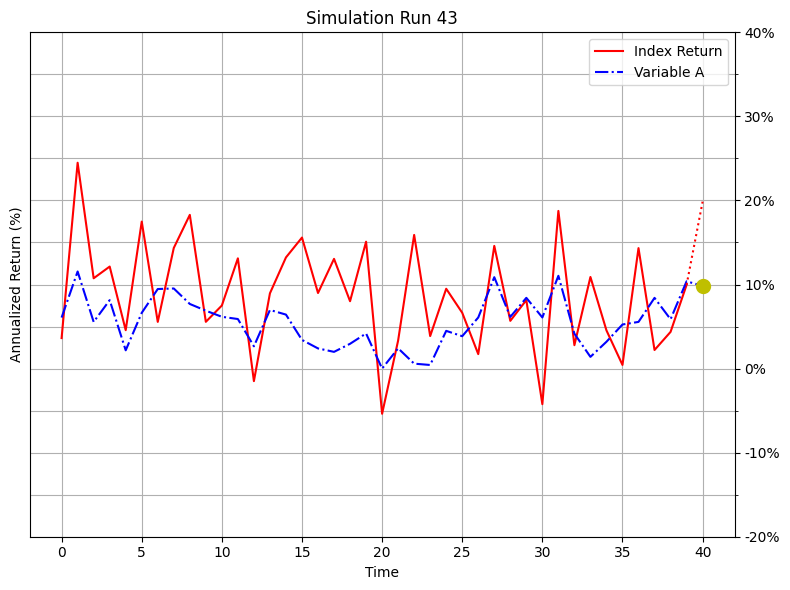

In [ ]:
# Aligned graph (no lag, no axis).

# Get the data for simulation 43.
lnr_ht_act_43 = lnr_ht_act[:, 42]
lnr_ht_fit_43 = lnr_ht_fit[:, 42]

# Define time vectors for plotting (MATLAB: k, g, m, n)
k = np.arange(0, 41)  # from -40 to 0 (inclusive)
g = np.arange(0, 40)  # from -40 to -1
m = np.arange(40, 41)  # 0 to 4
n = np.arange(39, 41)  # -1 to 4

# Plot the data for simulation 43.
plt.figure(figsize=(8, 6))
plt.plot(
    g,
    100 * lnr_ht_act_43[h : T - T_oos : h],
    "-r",
    linewidth=1.5,
    label="Index Return",
)
plt.plot(
    k,
    100 * lnr_ht_fit_43[0 : T - T_oos : h],
    "-.b",
    linewidth=1.5,
    label="Variable A",
)
plt.plot(m, 100 * lnr_ht_fit_43[T_is], "oy", markersize=8, markeredgewidth=3)
plt.plot(n, 100 * lnr_ht_act_43[T_is : T_is + h + 1 : h], ":r", linewidth=1.5)

plt.grid(True, which="both")
plt.gca().xaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().yaxis.set_minor_locator(plt.MultipleLocator(5))
plt.gca().yaxis.tick_right()  # place y-axis on right side
# plt.axis([-N_is + 1, 4, -20, 40])
# Set yhe y-axis limits to the range of the data.
plt.ylim([
    -20, 40])
plt.legend()
plt.gca().set_yticklabels([f"{int(tick)}%" for tick in plt.gca().get_yticks()])

plt.title(f"Simulation Run 43")
plt.xlabel("Time")
plt.ylabel("Annualized Return (%)")
plt.tight_layout()
#plt.savefig(f"sim_paths/Simulation_Paths_{h}Y/43_Path.png")
plt.show()
